<a href="https://colab.research.google.com/github/thaovtp825/pythonclass/blob/main/ScoreCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Xếp hạng tín nhiệm trong quản trị rủi ro ngân hàng(Hoạt động tín dụng)**


# **Xây dựng model ScoreCard**
Mô hình xây dựng để tính điểm tín nhiệm và phân loại khách hàng theo FICO score(Điểm FICO (fico score) là một hệ thống tính điểm được sử dụng để đo lường mức độ tín nhiệm của một người dựa trên dữ liệu trong năm lĩnh vực khác nhau. Những lĩnh vực này bao gồm lịch sử thanh toán, mức nợ hiện tại, loại tín dụng đã sử dụng, thời hạn lịch sử tín dụng và tài khoản tín dụng mới.)

Bộ dữ liệu sử dụng là bộ dữ liệu HMEQ. Bộ dữ liệu Home Equity(HMEQ) chứa thông tin về hồ sơ vay nợ với tài sản thế chấp là nhà cửa(tài sản nhà đất). Thuộc tính dự đoán(target) của bộ dữ liệu này là BAD, có 2 giá trị dùng để chỉ ra hồ sơ vay nợ xấu(defaulted).
*   BAD: 1 = Hồ sơ vay là vi phạm hoặc mất khả năng trả nợ; 0 = hồ sơ vay đã và đang trả nợ.
*   LOAN: Số tiền yêu cầu cho vay.
*   MORTDUE: Số tiền còn nợ trên tài sản nhà đất thế chấp.
*   VALUE: Giá trị hiện tại của tài sản nhà đất thế chấp.
*   REASON: Lý do vay tiền.
  *   DebtCon: vay để trả nợ
  *   HomeImp: vay để sửa chữa nhà.
*   JOB: Nghề nghiệp của khách hàng vay dựa trên 6 loại nghề nghiệp.
  *   Mgr: Quản lý
  *   Office: Văn phòng
  *   ProfExe: Giám đốc chuyên nghiệp
  *   Sales: Bán hàng
  *   Self: Nghề tự do
  *   Other: Các công việc còn lại.
*   YOJ: Số năm làm việc ở công việc hiện tại.
*   DEROG: Số lượng báo báo thông tin tín dụng xấu nghiêm trọng(major derogatory reports).
*   DELINQ: Số lần thất bại chi trả nợ cho hạn mức tín dụng
*   CLAGE: Tuổi tính theo tháng của tài khoản tín dụng lâu nhất.
*   NINQ: Số lượng hạn mức tín dụng gần đây.
*   CLNO: Tổng số hạn mức tín dụng đã dùng.
*   DEBTINC: Tỉ lệ giữa nợ và thu nhập.

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
data = pd.read_csv('http://www.creditriskanalytics.net/uploads/1/9/5/1/19511601/hmeq.csv', header = 0, sep = ',')
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


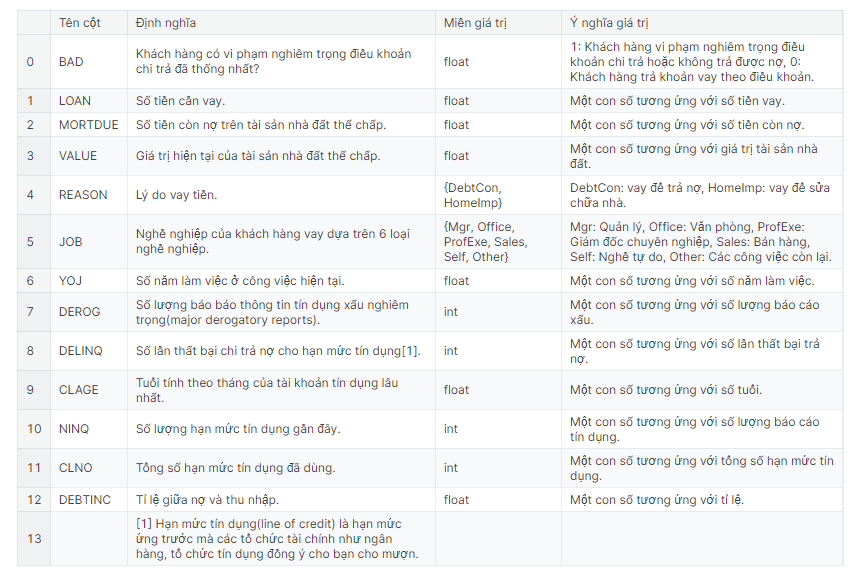

In [ ]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [ ]:
# Thống kê các thuộc tính thuộc dạng categorical
data_cat = data.select_dtypes(exclude='number')
data_cat.loc[:, "BAD"] = data.loc[:, "BAD"].astype(str)
data_cat.describe()

,REASON,JOB,BAD
count,5708,5681,5960
unique,2,6,2
top,DebtCon,Other,0
freq,3928,2388,4771


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


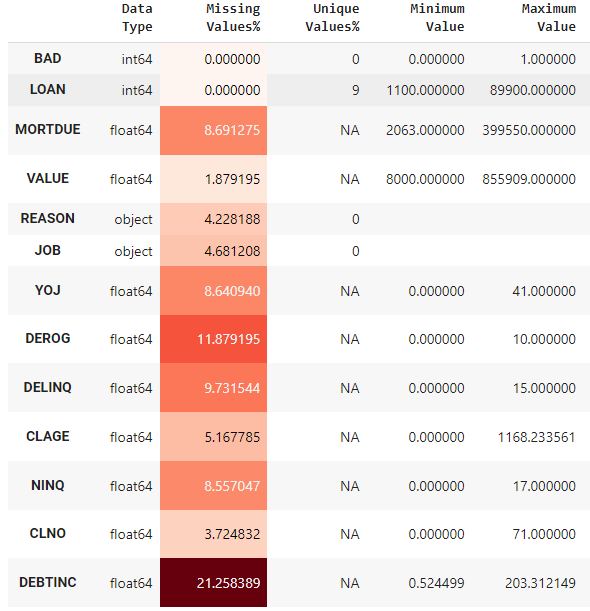

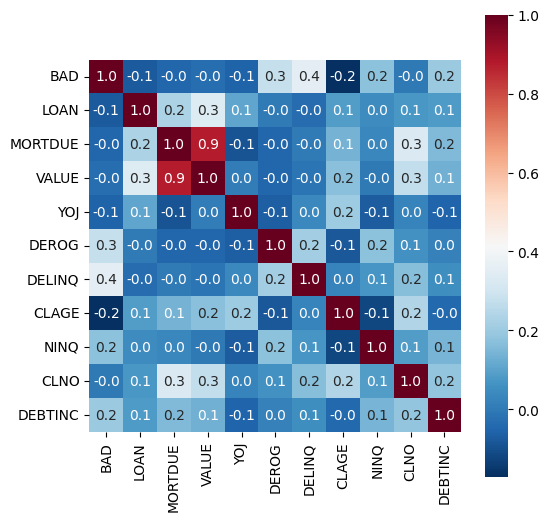

In [ ]:
# Vẽ biểu đồ thể hiện sự tương quan giữa các thuộc tính
data_number = data.select_dtypes('number')
plt.figure(figsize=(6, 6))
sns.heatmap(data_number.corr(), square=True, cmap='RdBu_r', annot=True,  fmt='.1f');

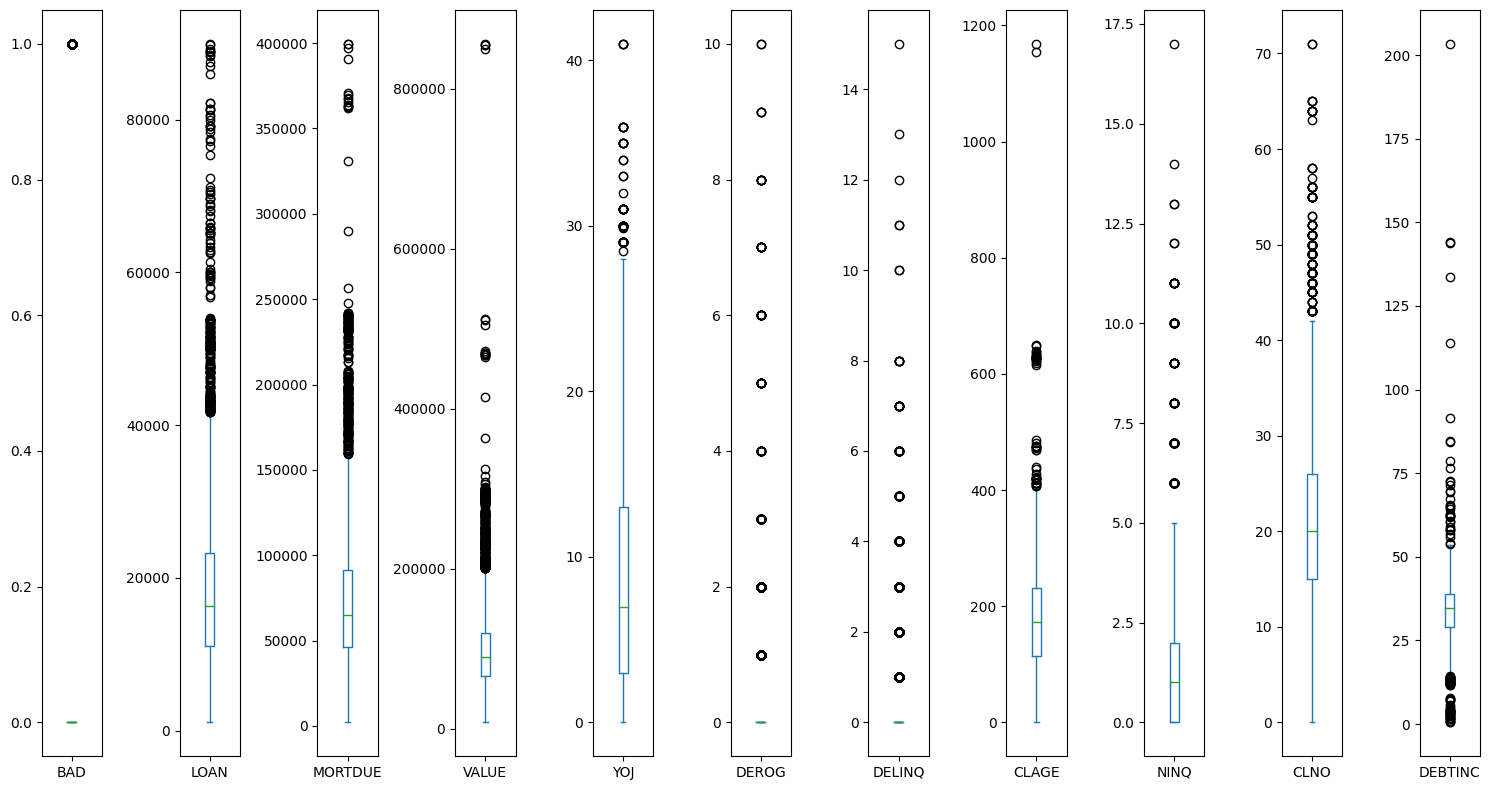

In [ ]:
#Vẽ boxplot các thuộc tính dạng numeric
data_number.plot(kind = "box", subplots = True, figsize = (15, 8));
plt.tight_layout()

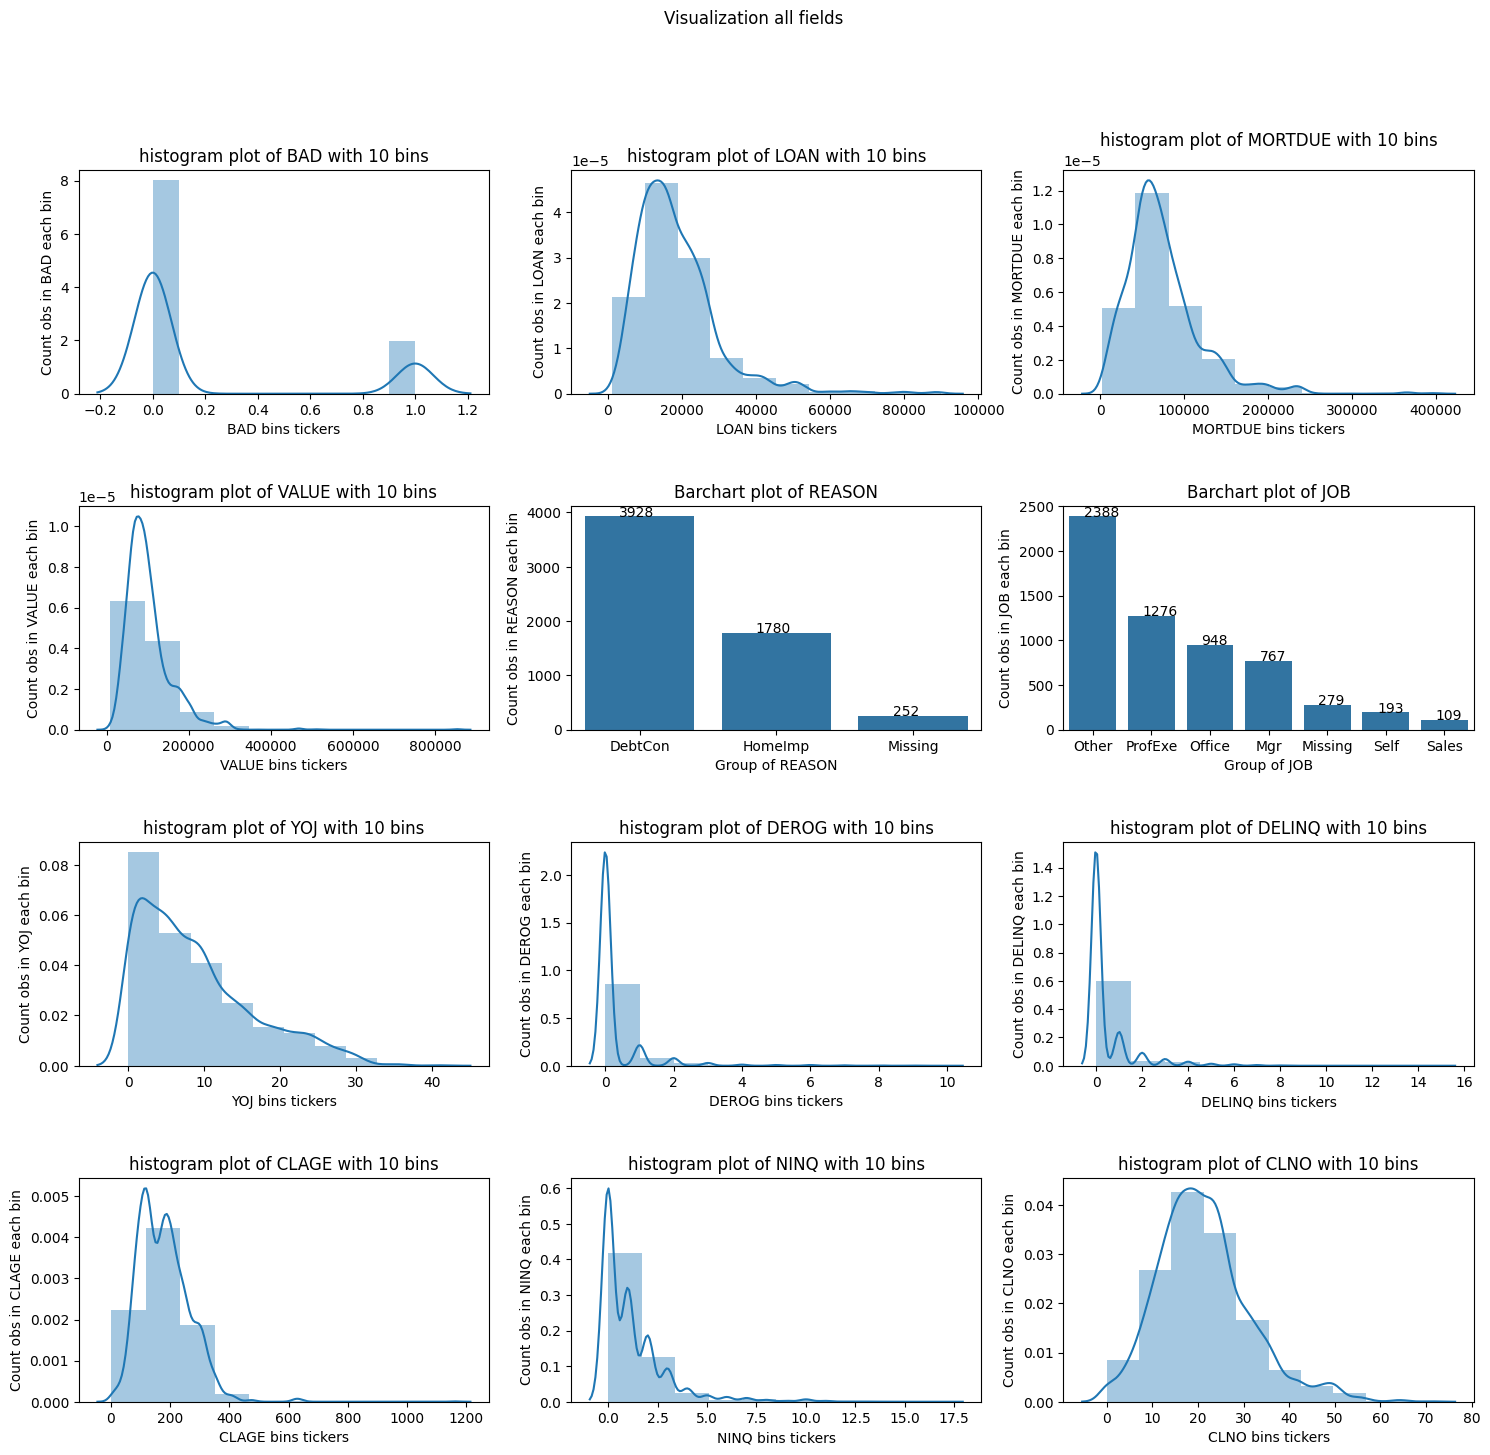

In [ ]:
# Biểu đồ histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(data.columns, data.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(data[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(data[fieldname], fieldname=fieldname)

fig.suptitle('Visualization all fields')
plt.show()

Nhận xét:
- Một số cột bị thiếu nhiều dữ liệu, đặc biệt là DEBTINC
- Mất cân bằng dữ liệu: Biến 'BAD' biểu thị tập dữ liệu không cân bằng, chỉ có 20% quan sát là nợ xấu.
- Độ lệch: Nhiều biến liên tục không có phân phối chuẩn và bị lệch
- Outlier: Các thuộc tính số có chứa giá trị outlier nhưng so với số lượng điểm dữ liệu thì không đáng kể(5960 điểm dữ liệu) và các giá trị của outlier cũng không quá lớn
- Tương quan giữa các biến tương đối yếu

=> Nhóm lựa chọn hồi quy logistic với WOE transformation để giải quyết các vấn đề này (như đã phân tích trong slide)

In [ ]:
# Xử lý missing data:
# - Đối với các biến định lượng, fill bằng mean
# - Đối với các biến định tính, fill 'Missing'
columns_num = data.select_dtypes(['float', 'int']).columns
data[columns_num] = data[columns_num].apply(lambda x: x.fillna(x.mean()), axis=0)

columns_obj = data.select_dtypes(['object']).columns
data[columns_obj] = data[columns_obj].apply(lambda x: x.fillna('Missing'), axis=0)


In [ ]:

MAX_VAL = 999999999
MIN_VAL = -MAX_VAL
# MAX_VAL và MIN_VAL là giá trị cực đại và cực tiểu, dùng để điều chỉnh các ngưỡng khi phân khoảng

def _bin_table(data, colname, n_bins = 10, qcut = None):
  """
  Input: dataframe, tên cột cần phân tích, số lượng khoảng (n_bins) và qcut
  Output: bảng tổng hợp số lượng quan sát, số lượng Good, Bad của các khoảng.
  """
  X = data[[colname, 'BAD']]
  #Sort theo colname:
  X = X.sort_values(colname)
  coltype = X[colname].dtype

  if coltype in ['float', 'int']:
    if qcut is None:
      try:
        # Phân chia dữ liệu thành các khoảng bằng pd.qcut (qcut: quantile cut, retbins: return bins)
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        # Do ta đã điều chỉnh 2 đầu mút, ta cần chia lại khoảng (bins)
        # Sử dụng pd.cut để làm việc này, pd.cut cũng tương tự như pd.qcut nhưng đầu vào nhận là các ngưỡng thres đã có chứ không phải số lượng bins
        # Tức là ta chỉ update bins

        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      # nếu qcut is not None, nghĩa là chúng ta chọn manual các ngưỡng thres
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]

  # Tạo bảng pivot thống kê số lượng mục BAD trong các khoảng
  df_GB = pd.pivot_table(X,
                index = ['bins'],
                values = ['BAD'],
                columns = ['BAD'],
                aggfunc = {
                    'BAD':np.size
                })
  # print(df_GB)
  # Đếm số lượng quan sát trong mỗi khoảng
  df_Count = pd.pivot_table(X,
                index = ['bins'],
                values = ['BAD'],
                aggfunc = {
                    'BAD': np.size
                })
  # print(df_Count)

  if coltype in ['float', 'int']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#BAD', '#GOOD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

In [ ]:
# Phân chia các bins theo ngưỡng cutpoints. Phù hợp với những biến thứ bậc.
df_summary, thres = _bin_table(data, 'DELINQ', qcut=[MIN_VAL, 2, MAX_VAL])
df_summary

,Thres,No_Obs,#BAD,#GOOD
bins,,,,
"(-999999999, 2]",2,5663,4674,989
"(2, 999999999]",999999999,297,97,200


In [ ]:
# Phân chia các bins theo khai báo số lượng bins. Phù hợp với các biến liên tục.
df_summary, thres = _bin_table(data, 'DEBTINC', n_bins=3)
df_summary

,Thres,No_Obs,#BAD,#GOOD
bins,,,,
"(-999999999.0, 33.455]",3.345471e+01,1987,1873,114
"(33.455, 36.224]",3.622436e+01,1986,1147,839
"(36.224, 999999999.0]",1.000000e+09,1987,1751,236


In [ ]:
def _WOE(data, colname, n_bins = None, min_obs = 100, qcut = None):

  # Thống kê bins và lấy ra thres hold ban đầu dựa vào _bin_table function
  df_summary, thres = _bin_table(data, colname, n_bins = n_bins, qcut = qcut)

  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0 (khi tính GOOD / BAD)
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})

  # Nếu đã set trước các ngưỡng phân khoảng, gộp các khoảng (bins) lại để đảm bảo có đủ quan sát tối thiểu tại mỗi khoảng
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = _bin_table(data, colname, qcut=new_thres)

  new_thres = thres

  # - GOOD/BAD: Tỷ lệ giữa số lượng tốt (`#GOOD`) và xấu (`#BAD`).
  # - %BAD: Tỷ lệ phần trăm các trường hợp xấu so với tổng số các trường hợp xấu.
  # - %GOOD: Tỷ lệ phần trăm các trường hợp tốt so với tổng số các trường hợp tốt.
  # - WOE: Tính toán Weight of Evidence, được tính bằng log của tỷ lệ `%GOOD` chia cho `%BAD`.
  # - IV: Information Value, được tính bằng công thức `(%GOOD - %BAD) * WOE`.

  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

# df_summary, IV, thres = _WOE(data, 'DEBTINC', n_bins = 7, min_obs= 100)
# df_summary

Information Value of DEBTINC column: 1.3795573580411762


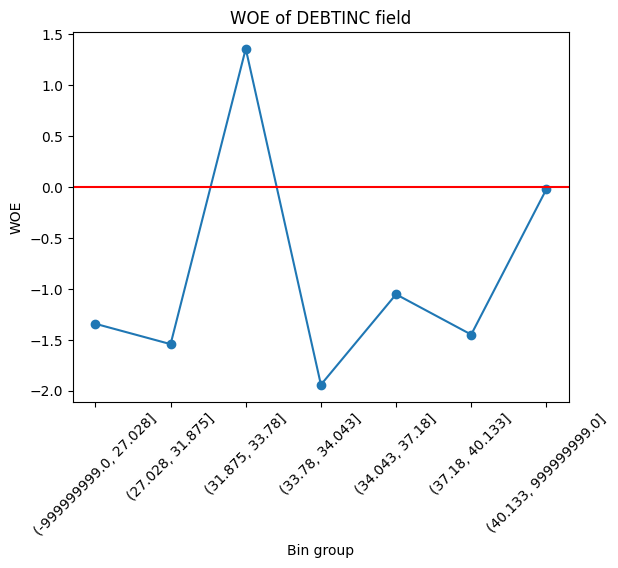

In [ ]:
def _plot(df_summary):
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WOE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')

df_summary, IV, thres = _WOE(data, 'DEBTINC', n_bins = 7, min_obs= 100)
df_summary
_plot(df_summary)

In [ ]:
# Đối với các biến numeric
WOE_dict=dict()
# Ta chia mặc định mỗi biến thành 10 bins, trong đó có NINQ (số lượng hạn mức tín dụng gần đây) và DEBTINC ( Nợ / Thu nhập) do đặc thù dữ liệu, sẽ được chia thành 2 bins và 7 bins
# Nếu chia quá nhỏ (số bins lớn) thì có thể có những bin trống
nbins = {'LOAN': 10, 'MORTDUE': 10, 'VALUE': 10, 'YOJ':10, 'CLAGE':10, 'NINQ': 2, 'CLNO':10, 'DEBTINC':7}
for (col, bins) in nbins.items():
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=bins)
  # print(col, df_summary, thres)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of LOAN column: 0.1601563338988017
Information Value of MORTDUE column: 0.05131351983314017
Information Value of VALUE column: 0.14188912125986042
Information Value of YOJ column: 0.06714693781095009
Information Value of CLAGE column: 0.22171042878294653
Information Value of NINQ column: 0.06965935231976197
Information Value of CLNO column: 0.06043698467606807
Information Value of DEBTINC column: 1.3795573580411762


In [ ]:
#Do các biến
#   - DEROG (Số lượng báo cáo thông tin tín dụng xấu nghiêm trọng),
#   - DELINQ (Số lần thất bại chi trả nợ cho hạn mức tín dụng)
# có xu hướng là biến thứ bậc hơn là biến liên tục nên áp dụng cách phân chia theo quantile sẽ tạo ra những khoảng bins có độ dài bằng 0. Do đó chúng ta sẽ phân chia theo ngưỡng cutpoint.
# Ngưỡng cutpoint được lựa chọn là 1, mang ý nghĩa đã vi phạm tín dụng hay chưa

for col in ['DEROG', 'DELINQ']:
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=5, qcut=[MIN_VAL, 1, MAX_VAL])
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of DEROG column: 0.25544310740061354
Information Value of DELINQ column: 0.41067752435125704


In [ ]:
#Tiếp theo ta sẽ tính toán IV cho các biến category là REASON và JOB.
for col in ['REASON', 'JOB']:
  df_summary, IV, thres = _WOE(data, colname=col)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of REASON column: 0.008618460238864025
Information Value of JOB column: 0.1237305657142077


In [ ]:
columns = []
IVs = []
for col in data.columns:
  if col != 'BAD':
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})

def _rank_IV(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)

,column,IV,rank
11,DEBTINC,1.379557,suspicious
7,DELINQ,0.410678,Strong
6,DEROG,0.255443,Medium
8,CLAGE,0.221710,Medium
0,LOAN,0.160156,Medium
2,VALUE,0.141889,Medium
4,JOB,0.123731,Medium
9,NINQ,0.069659,Weak
5,YOJ,0.067147,Weak
10,CLNO,0.060437,Weak


# **Hồi qui logistic**
Phương trình hồi qui logistic trong credit scorecard sẽ không hồi qui trực tiếp trên các biến gốc mà thay vào đó giá trị WOE ở từng biến sẽ được sử dụng thay thế để làm đầu vào


**Đầu tiên ta sẽ map giá trị WOE đã được tính trên các bin tương ứng với từng thông tin đầu vào của dữ liệu:**

In [ ]:
print(WOE_dict)

In [ ]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    data[col_woe] = data[col].map(d)
  except:
    print(col)

print(data)

**Tiếp theo ta lấy ra tập dữ liệu cho mô hình hồi quy logistic:**
*   Tập biến độc lập sẽ gồm các giá trị WOE của từng các tham số: LOAN, MORTDUE,VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC.
*   Biến phụ thuộc sẽ là thông tin BAD-Thông tin hồ sơ vay đang là nợ xấu hay không nợ xấu.





In [ ]:
X = data.filter(like='_WOE', axis = 1)
y = data['BAD']

print(X)
print(y)

**Tiếp đến là phân chia tập train và tập test theo tỷ lệ 80:20. Đảm bảo tỷ lệ của GOOD/BAD là cân bằng trên cả train và test.**

In [ ]:
from sklearn.model_selection import train_test_split

ids = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, ids, test_size = 0.2, stratify = y, shuffle = True, random_state = 123)


print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# **Train mô hình**

In [ ]:
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=1, penalty='l2')
#tot((tolarance)) là giá trị để dừng cập nhật gradient descent nếu khoảng thay đổi của hàm mất mát sau một bước huấn luyện nhỏ hơn tot.
#max_iter: Số lượt huấn luyện tối đa
#solver là phương pháp để giải bài toán tối ưu đối với cross entropy. ở đây ta dùng phương pháp Limited-memory BFGS(lbfgs)
#C: Hệ số nhân của thành phần penalty.
logit_model.fit(X_train, y_train)

# **Sau khi ta có mô hình, ta đi thực hiện đánh giá mô hình**

**Dự báo và kiểm tra accuracy**

Với acc = 0.8624 tương đương với độ chính xác mô hình là khoảng 86%. Theo accuracy này thì mô hình đauợc đánh giá là đủ tốt

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_test = logit_model.predict(X_test)
acc_test = accuracy_score(y_pred_test, y_test)

print('accuracy on test: ', acc_test)

**Đường cong ROC trên tập test**

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

Dựa trên ROC curve một mô hình hiệu quả khi tồn tại một điểm trên ROC curve gần với điểm có toạ độ (0, 1) trên đồ thị. Curve càng gần thì mô hình càng hiệu quả.
Nhìn đồ thị trên ta thấy đường ROC curve(màu cam) rấ gần với điểm có tọa độ (0,1). Ngoài ra ta có chỉ số AUC(Area Under the Curve) = 0.89 cho thấy rằng mô hình là đủ tốt.

**Kiểm định Kolmogorov-Smirnov:**

Đây là kiểm định đo lường sự khác biệt trong phân phối giữa GOOD và BAD theo các tỷ lệ ngưỡng threshold. Nếu mô hình có khả năng phân loại GOOD và BAD tốt thì đường cong phân phối xác suất tích lũy (cumulative distribution function - cdf) giữa GOOD và BAD phải có sự tách biệt lớn và ngược lại. Khi đó đường phân phối xác suất tích lũy của GOOD và BAD sẽ nằm sát nhau và tiệm cận đường chéo 45 độ. Kiểm định Kolmogorov-Smirnov sẽ kiểm tra giả thuyết Ho là hai phân phối xác suất GOOD và BAD không có sự khác biệt. Khi P-value < 0.05 bác bỏ giả thuyết Ho.

In [ ]:
#Tính toán phân phối xác suất tích lũy của GOOD và BAD
def _KM(y_pred, n_bins):
  _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
  cmd_BAD = []
  cmd_GOOD = []
  BAD_id = set(np.where(y_test == 0)[0])
  GOOD_id = set(np.where(y_test == 1)[0])
  total_BAD = len(BAD_id)
  total_GOOD = len(GOOD_id)
  for thres in thresholds:
    pred_id = set(np.where(y_pred <= thres)[0])
    # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
    cmd_BAD.append(per_BAD)
    # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
    cmd_GOOD.append(per_GOOD)
  cmd_BAD = np.array(cmd_BAD)
  cmd_GOOD = np.array(cmd_GOOD)
  return cmd_BAD, cmd_GOOD, thresholds

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
cmd_BAD, cmd_GOOD, thresholds = _KM(y_pred_prob_test, n_bins=20)

#Biểu đồ phân phối xác suất tích lũy của GOOD và BAD
def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
  plt.figure(figsize = (10, 8))
  plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
  plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
  plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
  plt.xlabel('% observation')
  plt.ylabel('% total GOOD/BAD')
  plt.title('Kolmogorov-Smirnov Curve')
  plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

**Đơn giản hơn ta đi kiểm định Kolmogorov-Smirnov test**

In [ ]:
from scipy import stats

stats.ks_2samp(cmd_BAD, cmd_GOOD)


# **Tính điểm credit score cho mỗi feature**

Bước cuối cùng là tính ra điểm tín nhiệm (credit scorecard) của mỗi khách hàng bằng cách tính điểm số cho mỗi feature (feature ở đây là một khoảng bin của biến liên tục hoặc một class của biến category). Điểm sẽ được scale theo công thức sau:

![](https://i.imgur.com/1t3pgG7.png)

Trong đó:
*   β Hệ số của biến trong phương trình hồi qui logistic.
*   α Hệ số chặn của phương trình hồi qui logistic.
*   WOE hệ số trọng số bằng chứng của mỗi feature.
*   n: Số lượng các biến của mô hình
*   Factor, offset: Là các tham số được thiết lập để tính Score:

![](https://i.imgur.com/2sCEZVY.png)


Odds là tỷ lệ giữa %BAD/%GOOD.

Pdo(point double odds ratio) được sử dụng trong đánh giá rủi ro tín dụng để giúp người cho vay hiểu được tác động của việc thay đổi điểm tín dụng đối với khả năng vỡ nợ. Ta có thể hiểu là nếu điểm tín dụng tăng 20 điểm thì tỷ lệ Odds đang là 1:10 xuống 1:20.

Ở bài này ta chọn Base_score là 600, odds 1:30 và pdo = 20.

Theo bộ dữ liệu ta có %Bad = 20%. Từ đó ta có odds = 1/4. Ta ước lượng pdo cho tỷ lệ odds này sẽ rơi vào khoảng -50.

**Áp dụng các công thức trên ta có hàm tính Credit Score như sau:**






In [ ]:
import numpy as np

def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

**Ta lấy thông tin beta và alpha từ mô hình hồi quy logistic**

In [ ]:
betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

**Tính Credit score cho từng features**

In [ ]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      col_woe = col+'_WOE'
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 12)
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE.head()

,Columns,Features,WOE,Betas,Scores
0,LOAN,"(-999999999.0, 7600.0]",0.898910,0.505048,17.136691
1,LOAN,"(7600.0, 10000.0]",0.154566,0.505048,44.254253
2,LOAN,"(10000.0, 12100.0]",-0.112535,0.505048,53.985171
3,LOAN,"(12100.0, 14400.0]",-0.158318,0.505048,55.653099
4,LOAN,"(14400.0, 16300.0]",0.162082,0.505048,43.980437


Sau khi ta có 1 dataframe về Credit Score trên từng feature ta lưu lại dưới dạng CSV và sử dụng nó cho việc tính toán điểm điểm tín nhiệm cho đối tượng khách hàng. Trong đó điểm điểm tín nhiệm của khách hàng sẽ là tổng Credit Score của khách hàng trên từng thông tin biến đâu vào đã nêu trên.

ta có bảng phân loại tín dụng theo FICO score như sau:
![](https://i.imgur.com/0o6HC9l.png)